##imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import time
import copy
import seaborn as sns

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

To import datasets:

Download manually the datasets from https://www.kaggle.com/shayanfazeli/heartbeat. Then uploading to your drive to the directory /content/drive/MyDrive/Deep_Learning/datasets (as written below), or you can choose other directory in drive, but change the link in the code.



In [ ]:
from google.colab import drive

drive_path = '/content/drive/MyDrive/Deep_Learning/datasets'
colab_path = '.'

drive.mount('/content/drive', force_remount=True)
!cp -r {drive_path} {colab_path} #line 1

Mounted at /content/drive


##data preparation

In [ ]:
def create_pd(train_path,test_path):
    train=pd.read_csv(train_path)
    test=pd.read_csv(test_path)
    train.columns=[x for x in range(188)]
    test.columns=[x for x in range(188)]
    return train,test

### MIT dataset

In [ ]:
mit_train_path="./datasets/mitbih_train.csv"
mit_test_path="./datasets/mitbih_test.csv"

In [ ]:
mit_train, mit_test= create_pd(mit_train_path,mit_test_path)
mit_train.head()

0         1         2         3         4         5         6    \
0  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
1  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
2  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
3  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   
4  0.927461  1.000000  0.626943  0.193437  0.094991  0.072539  0.043178   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.053541  0.093264  0.189983  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 188 columns]

In [ ]:
mit_classes = ['N','S','V','F','Q']

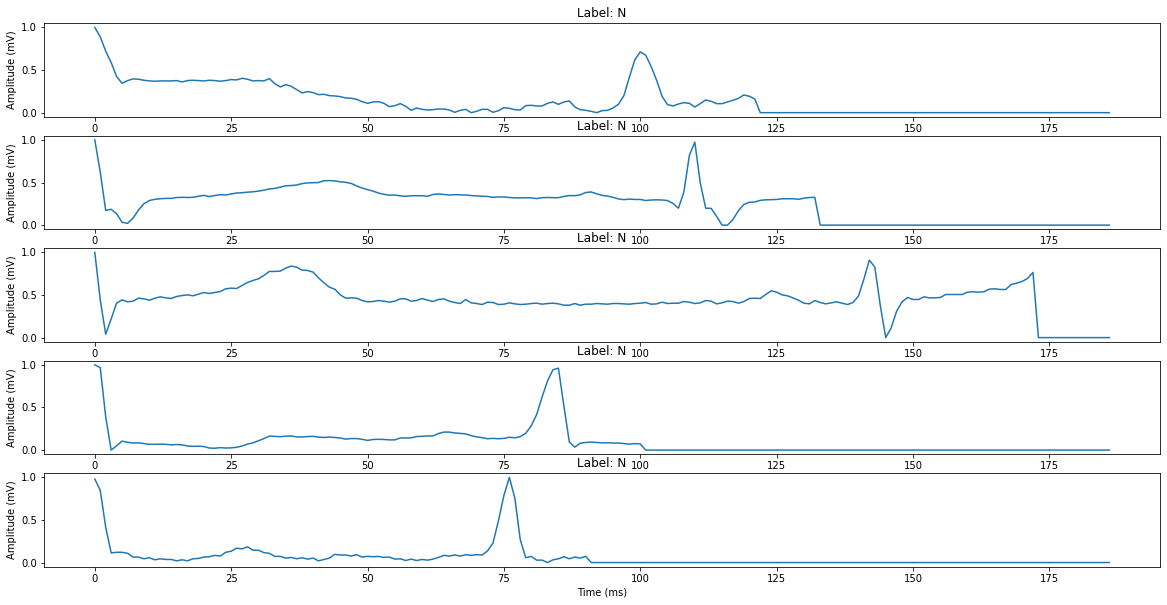

In [ ]:
#plot 5 ecg signals in the dataset and their corresponding labels 
fig, ax = plt.subplots(5, 1, figsize=(20, 10))
for i, j in enumerate(np.random.randint(0,len(mit_train),5)):
    ax[i].plot(mit_train.iloc[j, :187])
    ax[i].set_title(f'Label: {mit_classes[int(mit_train.iloc[j,187])]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

In [ ]:
print("train relative percentage: {:.3f}%".format(mit_train.shape[0]*100/(mit_train.shape[0]+mit_test.shape[0])))
print("test relative percentage: {:.3f}%".format(mit_test.shape[0]*100/(mit_train.shape[0]+mit_test.shape[0])))

train relative percentage: 79.998%
test relative percentage: 20.002%


In [ ]:
mit = pd.concat([mit_train,mit_test], axis=0, join='inner').sort_index()

In [ ]:
totals = mit.loc[:,187].value_counts().sort_index().sum()
class_sums = mit.loc[:,187].value_counts().sort_index()
mit_weights = [round(class_sums[i]/totals,2) for i in range(5)]
print("classes proportion: ",mit_weights)

classes proportion:  [0.83, 0.03, 0.07, 0.01, 0.07]


###ptb dataset

In [ ]:
ptb_normal_path="./datasets/ptbdb_normal.csv"
ptb_abnormal_path="./datasets/ptbdb_abnormal.csv"

In [ ]:
ptb_normal, ptb_abnormal= create_pd(ptb_normal_path,ptb_abnormal_path)
ptb = pd.concat([ptb_normal,ptb_abnormal], axis=0, join='inner').sort_index()
ptb.head()

0         1         2         3         4         5         6    \
0  1.000000  0.794681  0.375387  0.116883  0.000000  0.171923  0.283859   
0  1.000000  0.606941  0.384181  0.254237  0.223567  0.276836  0.253430   
1  1.000000  0.951613  0.923963  0.853303  0.791859  0.734255  0.672043   
1  0.909029  0.791482  0.423169  0.186712  0.000000  0.007836  0.063032   
2  1.000000  0.478893  0.056760  0.064176  0.081289  0.072732  0.055619   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.293754  0.325912  0.345083  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0  0.184826  0.153349  0.121872  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.685100  0.670507  0.667435  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.077002  0.074957  0.077342  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.048774  0.054478  0.041643  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
0  0.0  1.0  
1  0.0  1.0  
1  0.0  0.0  
2  0.0  0.0  

[5 rows x 188 columns]

In [ ]:
class_sums = ptb.loc[:,187].value_counts().sort_index()
ptb_weights = [round(class_sums[i]/len(ptb),2) for i in range(2)]
print("classes proportion: ",ptb_weights)

classes proportion:  [0.28, 0.72]


In [ ]:
ptb_train, ptb_test = train_test_split(ptb, test_size=0.2, random_state=0)

In [ ]:
ptb_classes = ['normal','abnormal']

##model

In [ ]:
class HeartBeatNet(nn.Module):
  def __init__(self,nb_class=5):
    super(HeartBeatNet, self).__init__()
    self.conv_layer = nn.Sequential(
        # Conv Layer block 1
        nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding='valid'),
        nn.BatchNorm1d(32),
        nn.ReLU(inplace=True),

        # Conv Layer block 2
        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding='valid'),
        nn.BatchNorm1d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool1d(kernel_size=3),

        # Conv Layer block 3
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding='valid'),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),

        # Conv Layer block 4
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding='valid'),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.AvgPool1d(kernel_size=3)
    )

    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.3),

        nn.Linear(4608, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),

        nn.Linear(1024, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),

        nn.Linear(256, 32),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),

        nn.Linear(32, nb_class)
    )
  def forward(self,x):
    """
    x: 1-dim vector of size (Batch ,1, HEARTBEAT_SIZE)
    return: forward pass of x to the convolution and fully connected layers
    """

    x = self.conv_layer(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)

    return x

##Train function and examples

device

In [ ]:
if torch.cuda.is_available():
    print("current cuda device: ", torch.cuda.current_device())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("running calculations on device: ", device)

current cuda device:  0
running calculations on device:  cuda:0


Define the accuracy and loss

In [ ]:
def calculate_measurements(model, dataloader, device, criterion, nb_class=5):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_ecg = 0
    running_loss = 0.0
    confusion_matrix = np.zeros([nb_class,nb_class], int)
    with torch.no_grad():
        for data in dataloader:
            ecgs, labels = data
            ecgs = ecgs.to(device)
            labels = labels.to(device)
            outputs = model(ecgs)

            # calculate the loss

            loss = criterion(outputs, labels)
            running_loss += loss.data.item()

            # calculate the total corrects

            _, predicted = torch.max(outputs.data, 1)
            total_ecg += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            ## calculate confusion matrix

            for i, l in enumerate(labels):
              confusion_matrix[l.item(), predicted[i].item()] += 1
    
    running_loss /= len(dataloader)
    model_accuracy = total_correct / total_ecg * 100
    confusion_matrix = confusion_matrix/np.reshape(np.sum(confusion_matrix,axis=1),newshape=(nb_class,1))
    return  model_accuracy, confusion_matrix, running_loss

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

train loop

In [ ]:
def train(model,loaders,criterion,optimizer,epochs,scheduler,early_stopping,trial=None):
    
    trainloader , validloader = loaders

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    # training loop
    for epoch in range(1, epochs + 1):
        model.train() # put in training mode
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            ecgs, labels = data
            # send them to device
            ecgs = ecgs.to(device)
            labels = labels.to(device)
            # forward + backward + optimize
            outputs = model(ecgs) # forward pass
            loss = criterion(outputs, labels) # calculate the loss

            optimizer.zero_grad() # zero the parameter gradients
            loss.backward() # backpropagation
            optimizer.step() # update parameters
            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)

        # Calculate training/validation set accuracy of the existing model
        train_accuracy,_,_ = calculate_measurements(model, trainloader, device, criterion)
        valid_accuracy,_,valid_loss = calculate_measurements(model, validloader, device, criterion)
        log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Validation accuracy: {:.3f}%  ".format(epoch, running_loss, 
                                                                                                        train_accuracy,valid_accuracy)
        print(log)

        # save model
        train_losses.append(running_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        # accuracy is used to track down a plateau
        scheduler.step(valid_accuracy) 

        # Early Stopping
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            break

        if trial != None:
            # report back to Optuna how far it is (epoch-wise) into the trial and how 
            # well it is doing (validation accuracy)
            trial.report(valid_accuracy, epoch) 
            
            # then, Optuna can decide if the trial should be pruned
            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    l = len(train_accuracies)
    # Accuracy plot
    figure = plt.figure(figsize=(15,8))
    ax = figure.add_subplot(1,1,1)
    ax.plot(range(1,l+1),train_accuracies,label = "train accuracy")
    ax.plot(range(1,l+1),valid_accuracies,label = "validation accuracy")
    ax.hlines(valid_accuracies[-1],xmin=0,xmax=l+1,colors='orange',linestyles='dashed',alpha=0.5)
    ax.hlines(train_accuracies[-1],xmin=0,xmax=l+1,colors='blue',linestyles='dashed',alpha=0.5)
    ax.legend()
    ax.set_title("Accuracies Curves")
    ax.set_xticks(range(1,l+1,2))
    ax.set_xlim(left=0)
    ax.set_xlabel("Epoch")
    _=ax.set_ylabel("Accuracy (%)")

    # loss plot
    figure = plt.figure(figsize=(15,8))
    ax = figure.add_subplot(1,1,1)
    ax.plot(range(1,l+1),train_losses,label = "train loss")
    ax.plot(range(1,l+1),valid_losses,label = "validation loss")
    ax.hlines(valid_losses[-1],xmin=0,xmax=l+1,colors='orange',linestyles='dashed',alpha=0.5)
    ax.hlines(train_losses[-1],xmin=0,xmax=l+1,colors='blue',linestyles='dashed',alpha=0.5)
    ax.legend()
    ax.set_title("Losses Curves")
    ax.set_xticks(range(1,l+1,2))
    ax.set_xlim(left=0)
    ax.set_xlabel("Epoch")
    _=ax.set_ylabel("Loss")
    
    return valid_accuracies[-1]

Model

In [ ]:
mit_model = HeartBeatNet().to(device)

N.o. weight parameters

In [ ]:
num_trainable_params = sum([p.numel() for p in mit_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)
size_model = 0
for param in mit_model.parameters():
  if param.data.is_floating_point():
    size_model += param.numel() * torch.finfo(param.data.dtype).bits
  else:
    size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")

num trainable weights:  5125125
model size: 164004000 / bit | 20.50 / MB


get the dataloaders

In [ ]:
def get_Dataloaders(train,test,batch_size):

    ttrain, tvalid = train_test_split(train, test_size=0.2, random_state=0)

    X_train = torch.tensor(ttrain.loc[:,:186].values,dtype = torch.float32).unsqueeze(1)
    y_train = torch.tensor(ttrain.loc[:,187:].values,dtype=torch.int64).squeeze()

    X_valid = torch.tensor(tvalid.loc[:,:186].values,dtype = torch.float32).unsqueeze(1)
    y_valid = torch.tensor(tvalid.loc[:,187:].values,dtype=torch.int64).squeeze()

    X_test = torch.tensor(test.loc[:,:186].values,dtype = torch.float32).unsqueeze(1)
    y_test = torch.tensor(test.loc[:,187:].values,dtype=torch.int64).squeeze()

    trainloader = torch.utils.data.DataLoader(TensorDataset(X_train,y_train),
    batch_size=batch_size, shuffle=True, num_workers=2)

    validloader = torch.utils.data.DataLoader(TensorDataset(X_valid,y_valid),
    batch_size=batch_size, shuffle=True, num_workers=2)

    testloader = torch.utils.data.DataLoader(TensorDataset(X_test,y_test),
    batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, validloader, testloader

hyperparameters

In [ ]:
nb_class = 5

batch_size = 64
learning_rate = 1e-4
epochs = 200

criterion = nn.CrossEntropyLoss(weight = 1/torch.tensor(mit_weights,dtype=torch.float32,device=device))

optimizer = torch.optim.Adam(mit_model.parameters(), lr=learning_rate)


# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                              verbose=True)

# Early Stopping
early_stopping = EarlyStopping(delta=0.0001, patience=10, verbose=True)


train

Epoch: 1 | Loss: 0.5735 | Training accuracy: 81.163% | Validation accuracy: 81.029%  
Epoch: 2 | Loss: 0.3394 | Training accuracy: 94.318% | Validation accuracy: 94.312%  
Epoch: 3 | Loss: 0.2795 | Training accuracy: 95.353% | Validation accuracy: 95.334%  
Epoch: 4 | Loss: 0.2414 | Training accuracy: 92.930% | Validation accuracy: 92.907%  
Epoch: 5 | Loss: 0.2072 | Training accuracy: 95.718% | Validation accuracy: 95.568%  
EarlyStopping counter: 1 out of 10
Epoch: 6 | Loss: 0.1901 | Training accuracy: 94.750% | Validation accuracy: 94.306%  
EarlyStopping counter: 2 out of 10
Epoch: 7 | Loss: 0.1753 | Training accuracy: 96.007% | Validation accuracy: 95.723%  
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
Epoch: 8 | Loss: 0.1350 | Training accuracy: 95.667% | Validation accuracy: 95.214%  
Epoch: 9 | Loss: 0.1227 | Training accuracy: 96.741% | Validation accuracy: 96.288%  
EarlyStopping counter: 1 out of 10
Epoch: 10 | Loss: 0.1209 | Training accuracy: 96.198% | Val

97.08754497173206

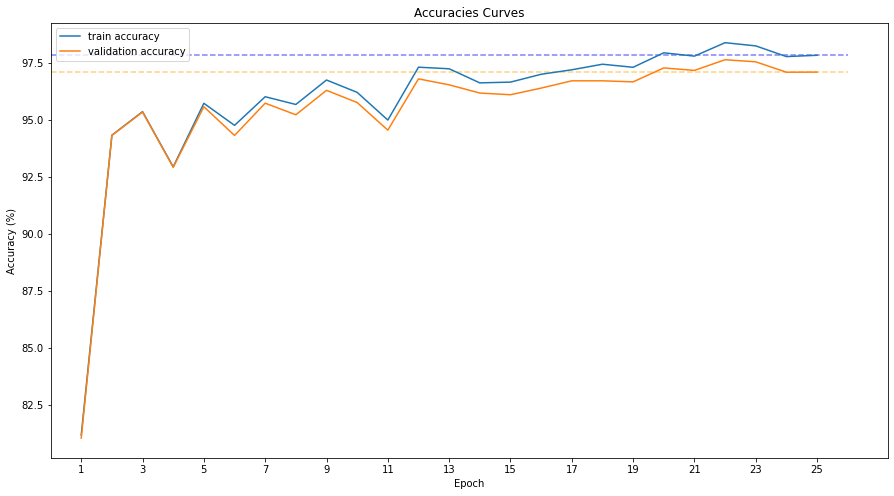

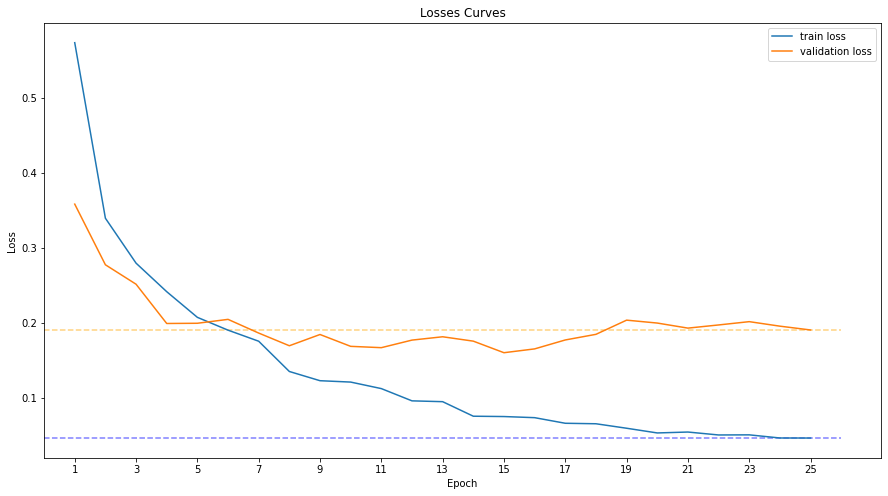

In [ ]:
trainloader,validloader,testloader = get_Dataloaders(mit_train,mit_test,batch_size)

train(mit_model,(trainloader,validloader),criterion,optimizer,epochs,scheduler,early_stopping)

calculating the test accuracy and confusion matrix

In [ ]:
test_accuracy,confusion_matrix,_ = calculate_measurements(mit_model, testloader, device, criterion, nb_class=5)
print("test accuracy is: {:5f}%".format(test_accuracy))

# plot confusion matrix
_=sns.heatmap(confusion_matrix, xticklabels = mit_classes,yticklabels = mit_classes, annot=True)

### now training the ptb

In [ ]:
nb_class = 2
ptb_model = HeartBeatNet(nb_class).to(device)

In [ ]:
batch_size = 64
learning_rate = 1e-4
epochs = 200

criterion = nn.CrossEntropyLoss(weight = 1/torch.tensor(ptb_weights,dtype=torch.float32,device=device))

optimizer = torch.optim.Adam(ptb_model.parameters(), lr=learning_rate)


# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                              verbose=True)

# Early Stopping
early_stopping = EarlyStopping(delta=0.0001, patience=10, verbose=True)

<ipython-input-76-83e9dd951b73>:32: RuntimeWarning: invalid value encountered in true_divide
  confusion_matrix = confusion_matrix/np.reshape(np.sum(confusion_matrix,axis=1),newshape=(nb_class,1))


Epoch: 1 | Loss: 0.4238 | Training accuracy: 89.605% | Validation accuracy: 89.777%  
Epoch: 2 | Loss: 0.2063 | Training accuracy: 91.731% | Validation accuracy: 91.452%  
Epoch: 3 | Loss: 0.1324 | Training accuracy: 96.005% | Validation accuracy: 95.919%  
EarlyStopping counter: 1 out of 10
Epoch: 4 | Loss: 0.1127 | Training accuracy: 97.272% | Validation accuracy: 97.036%  
Epoch: 5 | Loss: 0.0982 | Training accuracy: 97.756% | Validation accuracy: 96.950%  
EarlyStopping counter: 1 out of 10
Epoch: 6 | Loss: 0.0779 | Training accuracy: 99.270% | Validation accuracy: 98.582%  
Epoch: 7 | Loss: 0.0503 | Training accuracy: 98.969% | Validation accuracy: 98.196%  
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
EarlyStopping counter: 1 out of 10
Epoch: 8 | Loss: 0.0383 | Training accuracy: 99.699% | Validation accuracy: 99.098%  
Epoch: 9 | Loss: 0.0382 | Training accuracy: 99.656% | Validation accuracy: 98.926%  
Epoch: 10 | Loss: 0.0280 | Training accuracy: 99.560% | Val

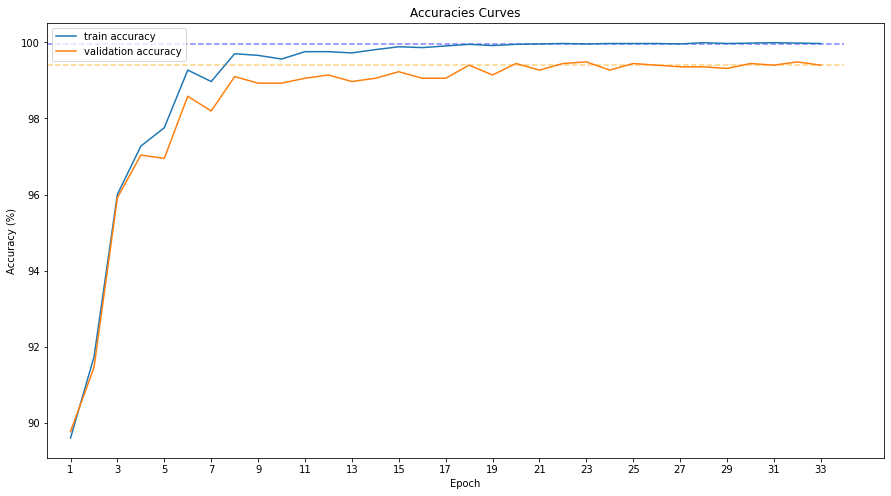

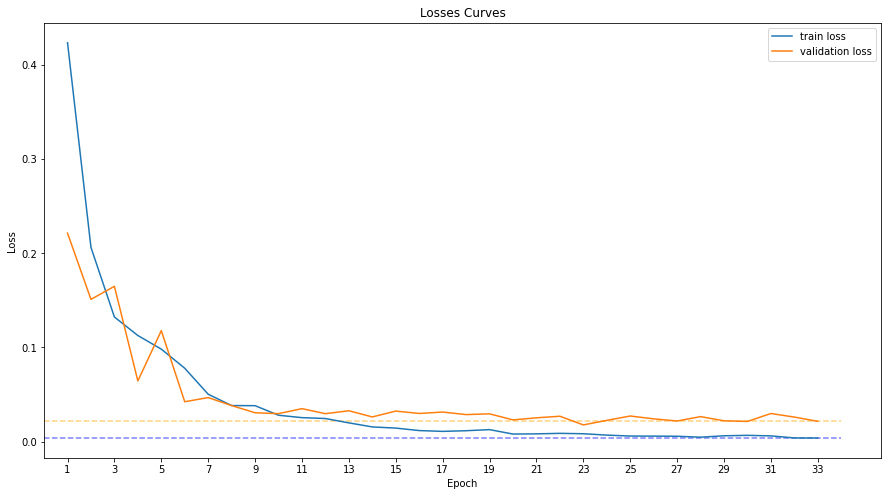

In [ ]:
trainloader,validloader,testloader = get_Dataloaders(ptb_train,ptb_test,batch_size)

since = time.time()
train(ptb_model,(trainloader,validloader),criterion,optimizer,epochs,scheduler,early_stopping)
ptb_time_elapsed = time.time() - since

test accuracy is: 99.415808%


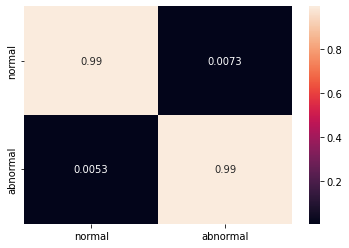

In [ ]:
ptb_test_accuracy,confusion_matrix,_ = calculate_measurements(ptb_model, testloader, device, criterion, nb_class)
print("test accuracy is: {:5f}%".format(ptb_test_accuracy))

# plot confusion matrix
_=sns.heatmap(confusion_matrix, xticklabels = ptb_classes,yticklabels = ptb_classes, annot=True)

##Tuning with optuna

In [ ]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.6 MB/s eta 0:00:00


In [ ]:
def compile_model(trial):
    # hyper-parameters
    epochs = 200
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True) # log=True, will use log scale
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True) # log=True, will use log scale
    batch_size = trial.suggest_int("batch_size", 64, 256) # batch_size will be between 64 and 256

    # Generate the model
    model = HeartBeatNet().to(device)

    # load data
    trainloader,validloader,testloader = get_Dataloaders(mit_train,mit_test,batch_size)

    # loss criterion
    criterion = nn.CrossEntropyLoss(weight = 1/torch.tensor(mit_weights,dtype=torch.float32,device=device))

    # optimizer - SGD, Adam, RMSProp...
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate, 
                                               weight_decay=weight_decay)
    
    # Learning Rate Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                                  verbose=True)

    # Early Stopping
    early_stopping = EarlyStopping(delta=0.0001, patience=10, verbose=True)

    # Train the trial
    value = train(model,(trainloader,validloader),criterion,optimizer,epochs,scheduler,early_stopping,trial)
    return value

[I 2023-01-27 11:22:23,398] A new study created in memory with name: ECG-CNN


Epoch: 1 | Loss: 1.5693 | Training accuracy: 49.616% | Validation accuracy: 50.060%  
Epoch: 2 | Loss: 1.4090 | Training accuracy: 33.397% | Validation accuracy: 33.453%  
Epoch: 3 | Loss: 1.1469 | Training accuracy: 47.908% | Validation accuracy: 48.118%  
Epoch: 4 | Loss: 0.9352 | Training accuracy: 53.791% | Validation accuracy: 53.812%  
Epoch: 5 | Loss: 0.7985 | Training accuracy: 62.126% | Validation accuracy: 62.075%  
Epoch: 6 | Loss: 0.6992 | Training accuracy: 77.275% | Validation accuracy: 77.180%  
Epoch: 7 | Loss: 0.6356 | Training accuracy: 73.420% | Validation accuracy: 73.417%  
Epoch: 8 | Loss: 0.5782 | Training accuracy: 75.021% | Validation accuracy: 74.719%  
Epoch 00008: reducing learning rate of group 0 to 1.1083e-03.
Epoch: 9 | Loss: 0.5425 | Training accuracy: 79.644% | Validation accuracy: 79.464%  
Epoch: 10 | Loss: 0.5209 | Training accuracy: 80.596% | Validation accuracy: 80.515%  
Epoch: 11 | Loss: 0.5077 | Training accuracy: 64.401% | Validation accuracy: 

[I 2023-01-27 11:28:32,743] Trial 0 finished with value: 86.27148649420364 and parameters: {'learning_rate': 0.002216634316799757, 'weight_decay': 1.6545657575131694e-05, 'batch_size': 194, 'optimizer': 'SGD'}. Best is trial 0 with value: 86.27148649420364.


Epoch: 40 | Loss: 0.3847 | Training accuracy: 86.528% | Validation accuracy: 86.271%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 0.5722 | Training accuracy: 87.203% | Validation accuracy: 86.883%  
Epoch: 2 | Loss: 0.3729 | Training accuracy: 92.038% | Validation accuracy: 91.868%  
Epoch: 3 | Loss: 0.3182 | Training accuracy: 95.107% | Validation accuracy: 94.843%  
Epoch: 4 | Loss: 0.2717 | Training accuracy: 85.557% | Validation accuracy: 85.506%  
EarlyStopping counter: 1 out of 10
Epoch: 5 | Loss: 0.2396 | Training accuracy: 95.894% | Validation accuracy: 95.700%  
EarlyStopping counter: 2 out of 10
Epoch: 6 | Loss: 0.2262 | Training accuracy: 93.744% | Validation accuracy: 93.621%  
Epoch: 7 | Loss: 0.2186 | Training accuracy: 94.520% | Validation accuracy: 94.341%  
Epoch: 8 | Loss: 0.2120 | Training accuracy: 91.799% | Validation accuracy: 91.440%  
EarlyStopping counter: 1 out of 10
Epoch: 9 | Loss: 0.1879 | Training accuracy: 93.612% | Validation accuracy: 93.650% 

[I 2023-01-27 11:35:54,908] Trial 1 finished with value: 97.55011135857461 and parameters: {'learning_rate': 0.00030295608864629674, 'weight_decay': 0.0002284160259527994, 'batch_size': 87, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 97.55011135857461.


Epoch: 32 | Loss: 0.0625 | Training accuracy: 98.201% | Validation accuracy: 97.550%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 0.6547 | Training accuracy: 81.680% | Validation accuracy: 81.794%  
Epoch: 2 | Loss: 0.4644 | Training accuracy: 89.072% | Validation accuracy: 88.858%  
Epoch: 3 | Loss: 0.3974 | Training accuracy: 87.890% | Validation accuracy: 88.019%  
EarlyStopping counter: 1 out of 10
Epoch: 4 | Loss: 0.3613 | Training accuracy: 89.501% | Validation accuracy: 89.641%  
Epoch: 5 | Loss: 0.3047 | Training accuracy: 89.107% | Validation accuracy: 89.167%  
EarlyStopping counter: 1 out of 10
Epoch: 6 | Loss: 0.2704 | Training accuracy: 93.044% | Validation accuracy: 92.947%  
Epoch: 7 | Loss: 0.2714 | Training accuracy: 92.981% | Validation accuracy: 92.765%  
Epoch 00007: reducing learning rate of group 0 to 1.3541e-03.
EarlyStopping counter: 1 out of 10
Epoch: 8 | Loss: 0.2033 | Training accuracy: 94.453% | Validation accuracy: 94.415%  
Epoch: 9 | Loss: 0.170

[I 2023-01-27 11:39:42,380] Trial 2 finished with value: 96.44223630860603 and parameters: {'learning_rate': 0.0027082869972702346, 'weight_decay': 2.125021058438371e-05, 'batch_size': 246, 'optimizer': 'Adam'}. Best is trial 1 with value: 97.55011135857461.


Epoch: 24 | Loss: 0.0504 | Training accuracy: 97.165% | Validation accuracy: 96.442%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 1.6121 | Training accuracy: 3.080% | Validation accuracy: 2.975%  
Epoch: 2 | Loss: 1.5901 | Training accuracy: 3.482% | Validation accuracy: 3.261%  
Epoch: 3 | Loss: 1.5589 | Training accuracy: 13.890% | Validation accuracy: 14.128%  
Epoch: 4 | Loss: 1.5062 | Training accuracy: 25.498% | Validation accuracy: 25.316%  
Epoch: 5 | Loss: 1.4179 | Training accuracy: 34.017% | Validation accuracy: 34.133%  
Epoch: 6 | Loss: 1.2999 | Training accuracy: 42.098% | Validation accuracy: 42.288%  
Epoch: 7 | Loss: 1.1870 | Training accuracy: 51.356% | Validation accuracy: 51.779%  
Epoch 00007: reducing learning rate of group 0 to 5.5565e-04.
Epoch: 8 | Loss: 1.1004 | Training accuracy: 52.499% | Validation accuracy: 52.864%  
Epoch: 9 | Loss: 1.0536 | Training accuracy: 55.520% | Validation accuracy: 55.776%  
Epoch: 10 | Loss: 1.0147 | Training accuracy:

[I 2023-01-27 11:49:48,756] Trial 3 finished with value: 69.81897093255668 and parameters: {'learning_rate': 0.0011113093191053886, 'weight_decay': 0.0002587008872571861, 'batch_size': 237, 'optimizer': 'SGD'}. Best is trial 1 with value: 97.55011135857461.


Epoch: 68 | Loss: 0.7086 | Training accuracy: 69.607% | Validation accuracy: 69.819%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 1.4819 | Training accuracy: 50.945% | Validation accuracy: 51.322%  
Epoch: 2 | Loss: 1.0446 | Training accuracy: 65.061% | Validation accuracy: 65.365%  
Epoch: 3 | Loss: 0.7555 | Training accuracy: 76.703% | Validation accuracy: 76.552%  
Epoch: 4 | Loss: 0.6086 | Training accuracy: 80.990% | Validation accuracy: 80.961%  
Epoch: 5 | Loss: 0.5212 | Training accuracy: 86.350% | Validation accuracy: 86.163%  
Epoch: 6 | Loss: 0.4577 | Training accuracy: 85.068% | Validation accuracy: 84.752%  
Epoch: 7 | Loss: 0.4204 | Training accuracy: 87.794% | Validation accuracy: 87.574%  
Epoch 00007: reducing learning rate of group 0 to 1.6203e-03.
Epoch: 8 | Loss: 0.3892 | Training accuracy: 87.046% | Validation accuracy: 86.991%  
Epoch: 9 | Loss: 0.3713 | Training accuracy: 86.331% | Validation accuracy: 86.357%  
EarlyStopping counter: 1 out of 10
Epoch:

[I 2023-01-27 11:57:53,322] Trial 4 finished with value: 91.77659756724344 and parameters: {'learning_rate': 0.003240617328308177, 'weight_decay': 4.686187542132528e-05, 'batch_size': 128, 'optimizer': 'SGD'}. Best is trial 1 with value: 97.55011135857461.


Epoch: 47 | Loss: 0.2517 | Training accuracy: 91.893% | Validation accuracy: 91.777%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 5.6056 | Training accuracy: 53.455% | Validation accuracy: 53.538%  


[I 2023-01-27 11:58:12,145] Trial 5 pruned. 


Epoch: 2 | Loss: 0.9451 | Training accuracy: 44.569% | Validation accuracy: 44.366%  
EarlyStopping counter: 1 out of 10
Epoch: 1 | Loss: 1.5784 | Training accuracy: 60.048% | Validation accuracy: 60.522%  


[I 2023-01-27 11:58:29,971] Trial 6 pruned. 


Epoch: 2 | Loss: 1.4744 | Training accuracy: 57.944% | Validation accuracy: 58.283%  
Epoch: 1 | Loss: 0.6170 | Training accuracy: 88.290% | Validation accuracy: 88.710%  
Epoch: 2 | Loss: 0.4587 | Training accuracy: 88.484% | Validation accuracy: 88.413%  
Epoch: 3 | Loss: 0.4170 | Training accuracy: 94.403% | Validation accuracy: 94.415%  
EarlyStopping counter: 1 out of 10
Epoch: 4 | Loss: 0.3630 | Training accuracy: 87.586% | Validation accuracy: 88.036%  
Epoch: 5 | Loss: 0.3451 | Training accuracy: 88.033% | Validation accuracy: 87.671%  
Epoch: 6 | Loss: 0.3378 | Training accuracy: 90.476% | Validation accuracy: 90.383%  
EarlyStopping counter: 1 out of 10
Epoch: 7 | Loss: 0.3049 | Training accuracy: 87.702% | Validation accuracy: 87.311%  
Epoch: 8 | Loss: 0.2962 | Training accuracy: 84.496% | Validation accuracy: 84.364%  
EarlyStopping counter: 1 out of 10
Epoch: 9 | Loss: 0.2817 | Training accuracy: 89.843% | Validation accuracy: 89.589%  
Epoch: 10 | Loss: 0.2686 | Training

[I 2023-01-27 12:03:57,605] Trial 7 finished with value: 96.94477756838559 and parameters: {'learning_rate': 0.0019363408286732962, 'weight_decay': 0.0007584741593005444, 'batch_size': 166, 'optimizer': 'Adam'}. Best is trial 1 with value: 97.55011135857461.


Epoch: 32 | Loss: 0.0779 | Training accuracy: 97.627% | Validation accuracy: 96.945%  
Epoch 00032: reducing learning rate of group 0 to 1.2102e-04.
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 0.5966 | Training accuracy: 81.717% | Validation accuracy: 81.897%  
Epoch: 2 | Loss: 0.4019 | Training accuracy: 89.583% | Validation accuracy: 89.641%  
Epoch: 3 | Loss: 0.3451 | Training accuracy: 93.867% | Validation accuracy: 93.998%  
Epoch: 4 | Loss: 0.2927 | Training accuracy: 91.542% | Validation accuracy: 91.554%  
Epoch: 5 | Loss: 0.2715 | Training accuracy: 87.693% | Validation accuracy: 87.197%  
EarlyStopping counter: 1 out of 10
Epoch: 6 | Loss: 0.2435 | Training accuracy: 83.705% | Validation accuracy: 83.056%  
Epoch: 7 | Loss: 0.2278 | Training accuracy: 90.918% | Validation accuracy: 90.709%  
Epoch 00007: reducing learning rate of group 0 to 6.8333e-04.
Epoch: 8 | Loss: 0.1631 | Training accuracy: 96.041% | Validation accuracy: 95.860%  
Epoch: 9 | Loss: 0.1475 | Trai

[I 2023-01-27 12:07:24,623] Trial 8 finished with value: 97.18462680600766 and parameters: {'learning_rate': 0.0013666606317623026, 'weight_decay': 7.487761325620746e-05, 'batch_size': 182, 'optimizer': 'Adam'}. Best is trial 1 with value: 97.55011135857461.


Epoch: 21 | Loss: 0.0479 | Training accuracy: 97.818% | Validation accuracy: 97.185%  
EarlyStopping counter: 10 out of 10


[I 2023-01-27 12:07:33,696] Trial 9 pruned. 


Epoch: 1 | Loss: 0.7262 | Training accuracy: 71.202% | Validation accuracy: 70.784%  
Study statistics: 
 Number of finished trials:  10
 Number of pruned trials:  3
 Number of complete trials:  7
Best trial:
 Value:  97.55011135857461
 Params: 
 learning_rate: 0.00030295608864629674
 weight_decay: 0.0002284160259527994
 batch_size: 87
 optimizer: RMSprop


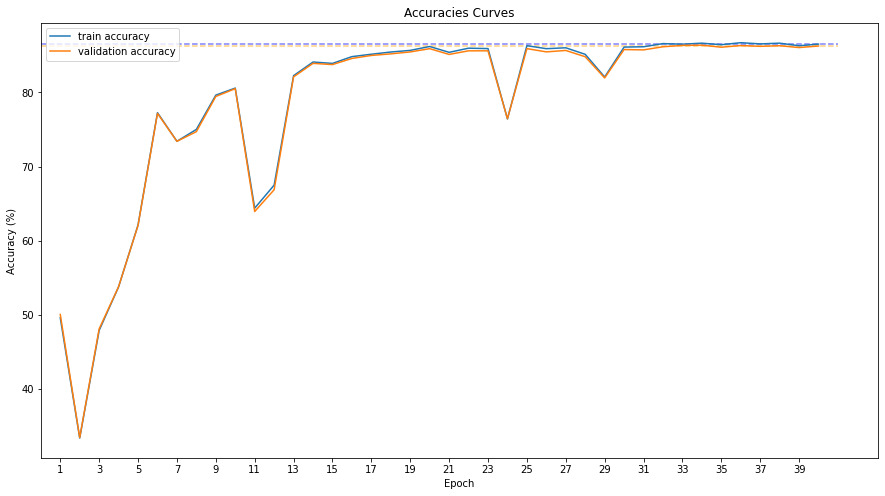

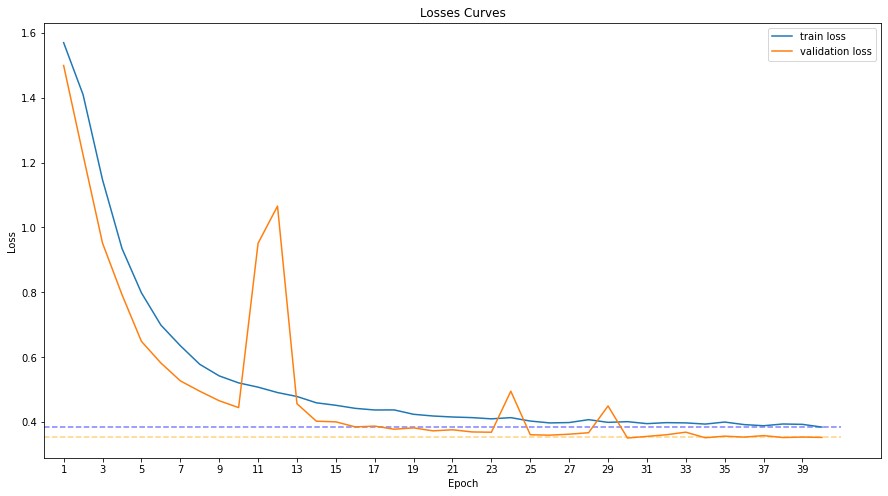

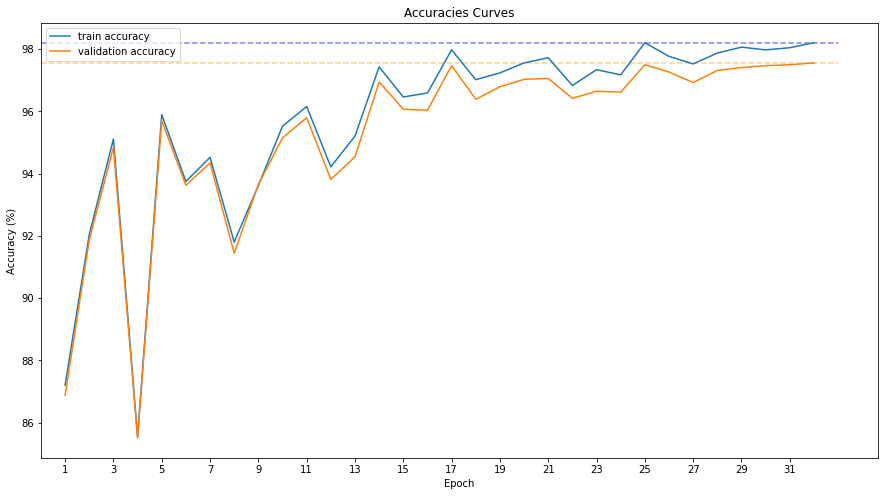

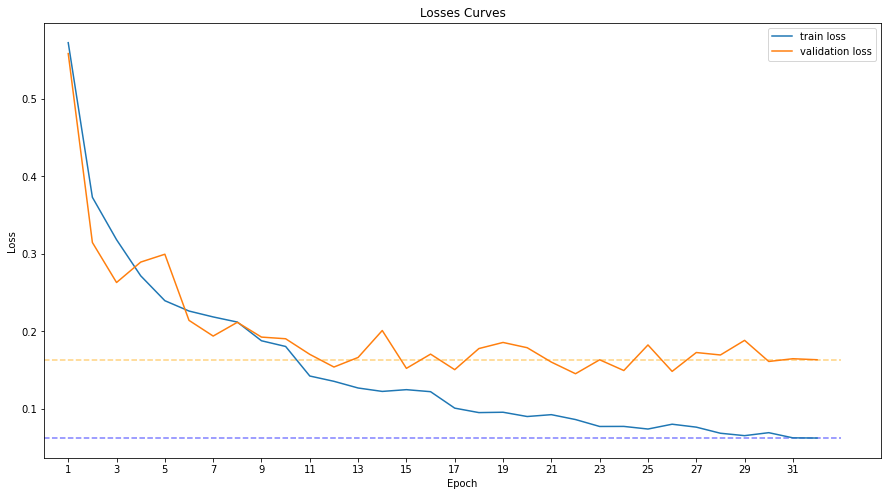

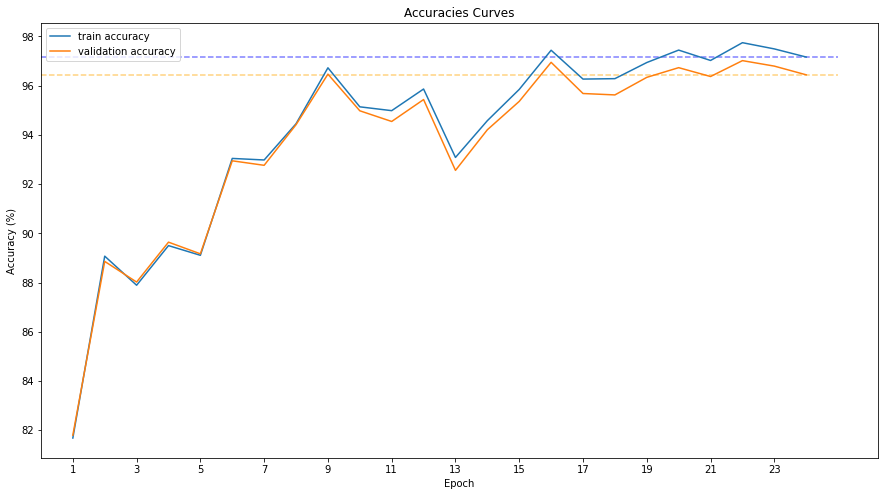

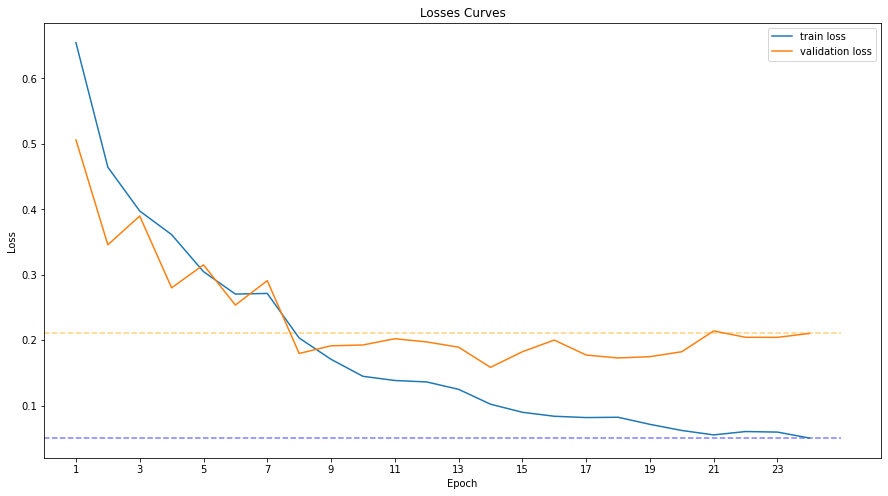

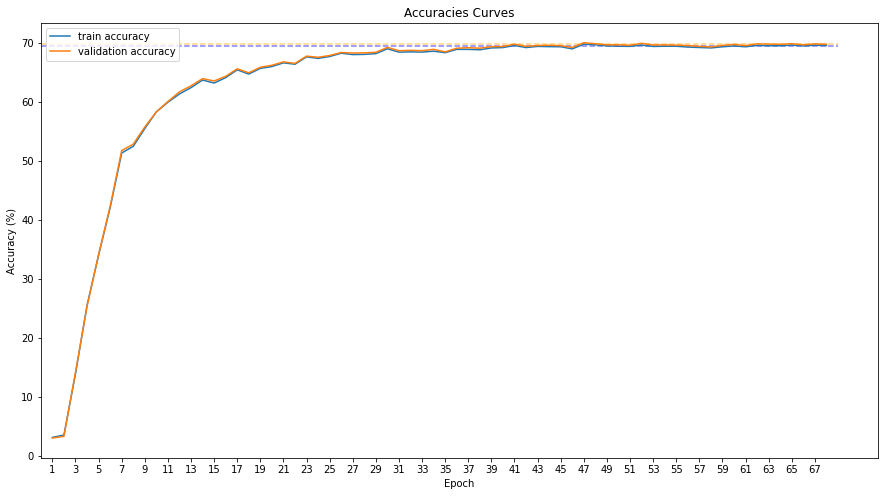

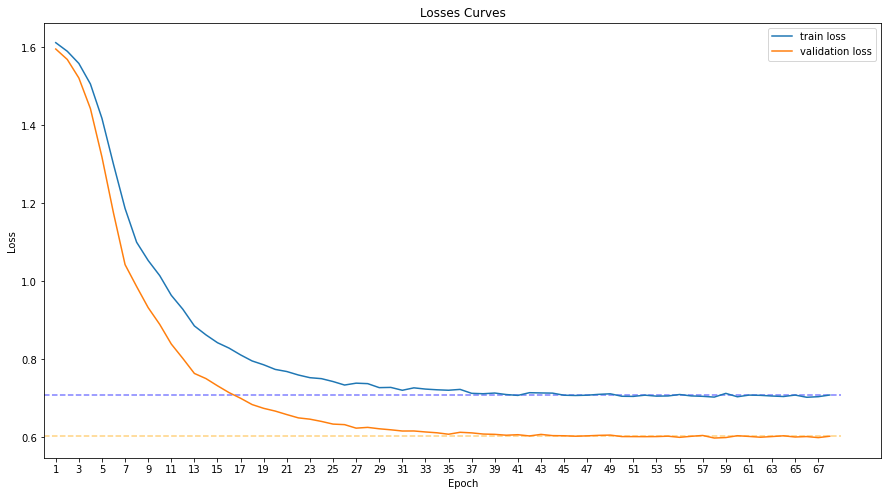

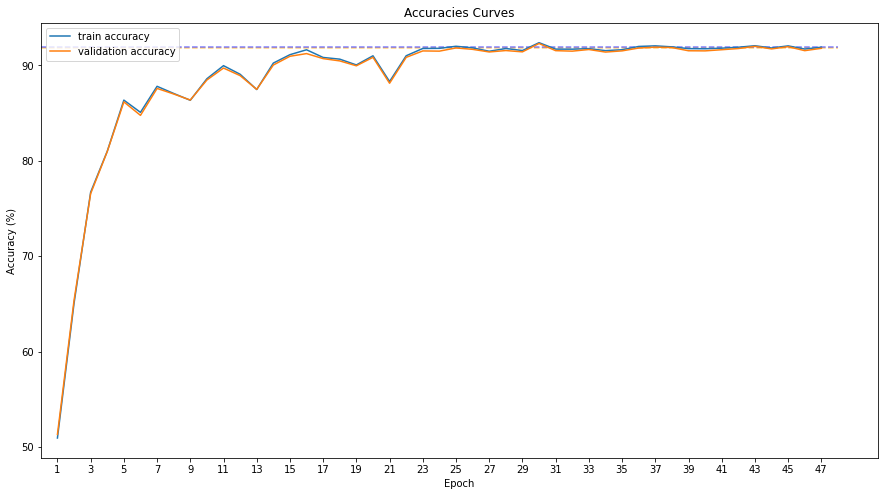

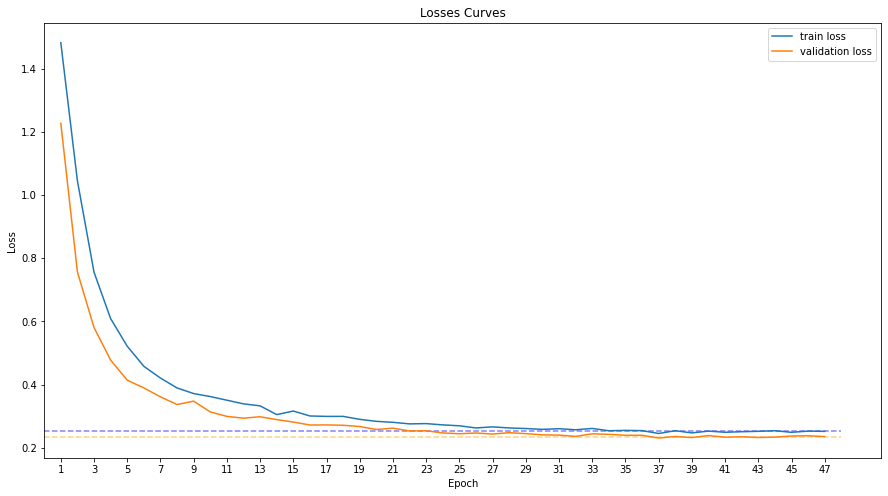

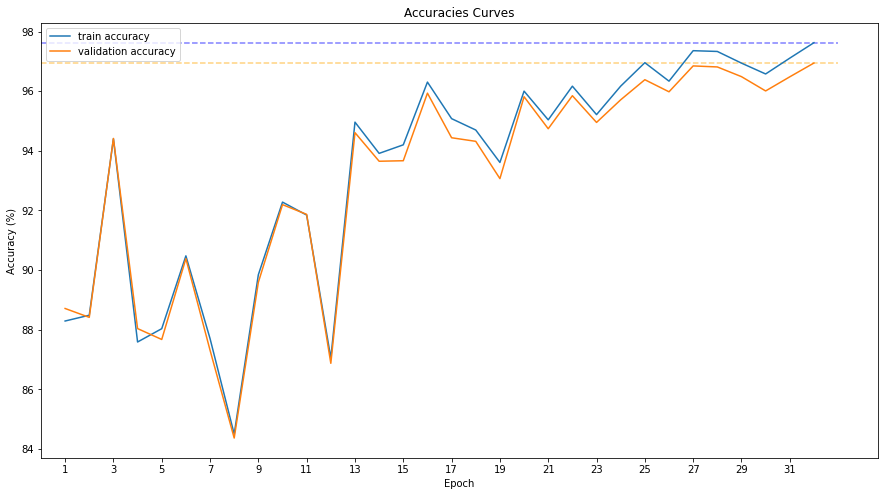

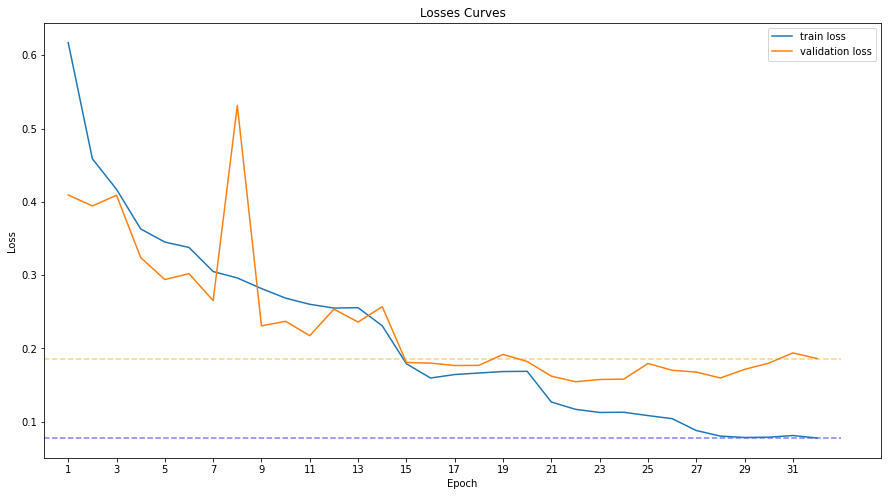

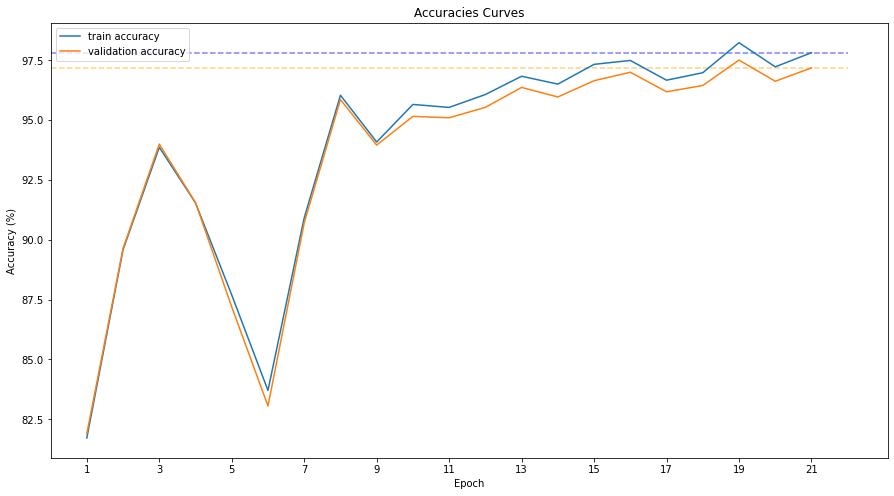

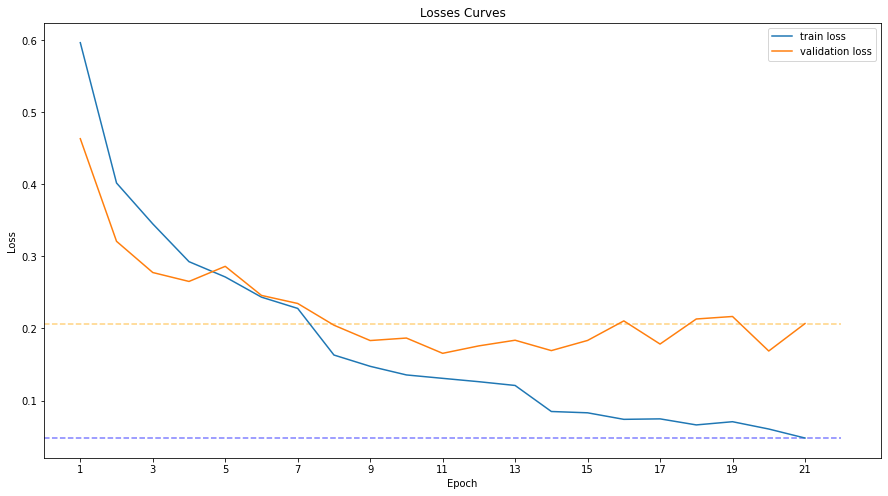

In [ ]:
# Compile with Optuna
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="ECG-CNN", direction="maximize", sampler=sampler)
study.optimize(compile_model, n_trials=10)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
 print(" {}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_param_importances(study)

taking the optuna hyperparams

In [ ]:
mit_model = HeartBeatNet().to(device)

In [ ]:
nb_class = 5

batch_size = 87
learning_rate = 0.00030295608864629674
epochs = 200
weight_dec = 0.0002284160259527994

criterion = nn.CrossEntropyLoss(weight = 1/torch.tensor(mit_weights,dtype=torch.float32,device=device))

optimizer = torch.optim.RMSprop(mit_model.parameters(), lr=learning_rate,weight_decay=weight_dec)


# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                              verbose=True)

# Early Stopping
early_stopping = EarlyStopping(delta=0.0001, patience=10, verbose=True)

Epoch: 1 | Loss: 0.5606 | Training accuracy: 94.590% | Validation accuracy: 94.590%  
Epoch: 2 | Loss: 0.3902 | Training accuracy: 89.406% | Validation accuracy: 89.406%  
Epoch: 3 | Loss: 0.3151 | Training accuracy: 89.702% | Validation accuracy: 89.702%  
EarlyStopping counter: 1 out of 10
Epoch: 4 | Loss: 0.2880 | Training accuracy: 96.341% | Validation accuracy: 96.341%  
Epoch: 5 | Loss: 0.2581 | Training accuracy: 95.383% | Validation accuracy: 95.383%  
Epoch: 6 | Loss: 0.2436 | Training accuracy: 95.426% | Validation accuracy: 95.426%  
Epoch: 7 | Loss: 0.2284 | Training accuracy: 92.012% | Validation accuracy: 92.012%  
Epoch: 8 | Loss: 0.2181 | Training accuracy: 92.462% | Validation accuracy: 92.462%  
Epoch 00008: reducing learning rate of group 0 to 1.5148e-04.
EarlyStopping counter: 1 out of 10
Epoch: 9 | Loss: 0.1618 | Training accuracy: 93.488% | Validation accuracy: 93.488%  
Epoch: 10 | Loss: 0.1486 | Training accuracy: 93.832% | Validation accuracy: 93.832%  
Epoch: 

98.23534450758117

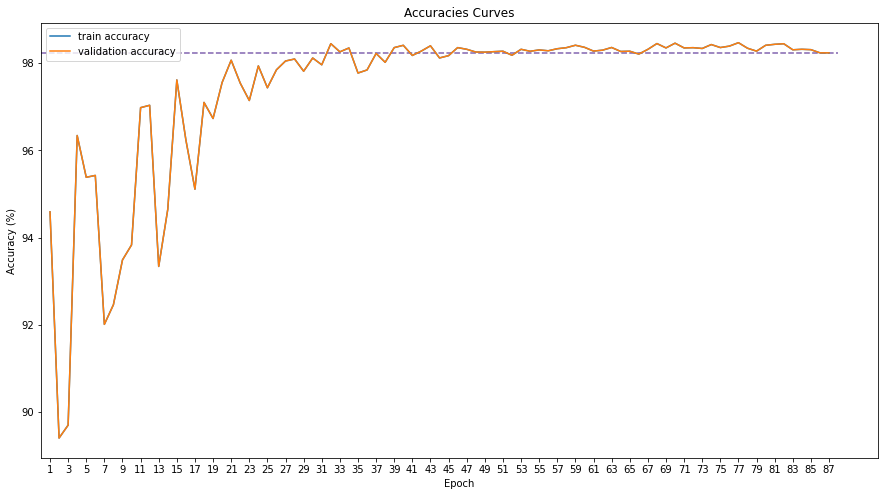

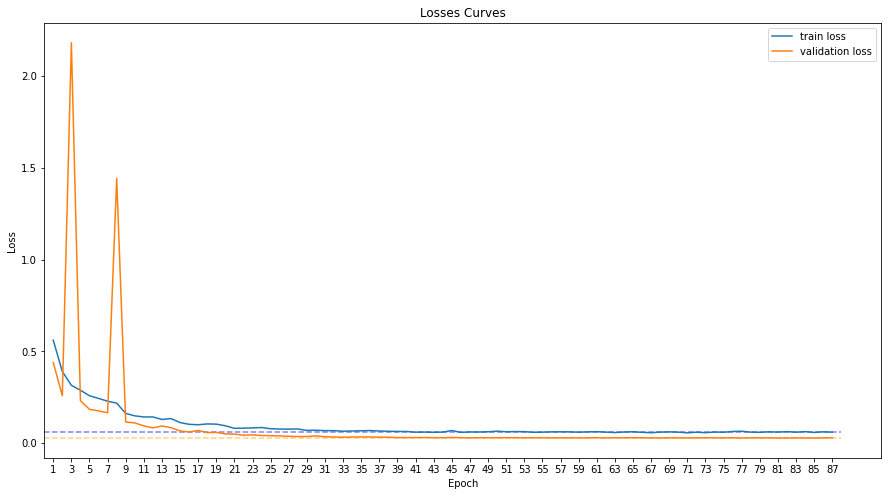

In [ ]:
trainloader,validloader,testloader = get_Dataloaders(mit_train,mit_test,batch_size)
train(mit_model,(trainloader,trainloader),criterion,optimizer,epochs,scheduler,early_stopping)

test accuracy is: 97.263716%


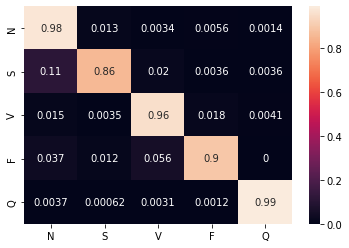

In [ ]:
test_accuracy,confusion_matrix,_ = calculate_measurements(mit_model, testloader, device, criterion, nb_class=5)
print("test accuracy is: {:5f}%".format(test_accuracy))

# plot confusion matrix
_=sns.heatmap(confusion_matrix, xticklabels = mit_classes,yticklabels = mit_classes, annot=True)

- we ended with test accuracy of 97.26%!!!! (93.8% balanced accuracy)

## Trial to freeze MIT model to train the PTB model

In [ ]:
def set_parameter_requires_grad(model):
  # frozen model
  model.requires_grad_(False)
  for param in model.parameters():
    param.requires_grad = False 

In [ ]:
def train_freezed(layers):
  freezed_model = copy.deepcopy(mit_model)
  set_parameter_requires_grad(freezed_model)

  # determine the trainable layers
  if layers<1:
    return
  freezed_model.fc_layer[10] = nn.Linear(in_features=32, out_features=2, bias=True).to(device)
  if layers>1:
    freezed_model.fc_layer[7] = nn.Linear(in_features=256, out_features=32, bias=True).to(device)
    if layers > 2:
      freezed_model.fc_layer[4] = nn.Linear(in_features=1024, out_features=256, bias=True).to(device)
      if layers > 3:
        freezed_model.fc_layer[1] = nn.Linear(in_features=4608, out_features=1024, bias=True).to(device)
        if layers>4:
          return

  params_to_update = []
  for name,param in freezed_model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print(name)

  batch_size = 64
  learning_rate = 1e-4
  epochs = 200

  criterion = nn.CrossEntropyLoss(weight = 1/torch.tensor(ptb_weights,dtype=torch.float32,device=device))

  optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)


  # Learning Rate Scheduler
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                                verbose=True)

  # Early Stopping
  early_stopping = EarlyStopping(delta=0.0001, patience=10, verbose=True)

  trainloader,validloader,testloader = get_Dataloaders(ptb_train,ptb_test,batch_size)

  since = time.time()
  train(freezed_model,(trainloader,validloader),criterion,optimizer,epochs,scheduler,early_stopping)
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  test_accuracy,_,_ = calculate_measurements(freezed_model, testloader, device, criterion, nb_class)

  return test_accuracy,time_elapsed

fc_layer.10.weight
fc_layer.10.bias


<ipython-input-76-83e9dd951b73>:32: RuntimeWarning:

invalid value encountered in true_divide



Epoch: 1 | Loss: 1.4819 | Training accuracy: 42.064% | Validation accuracy: 42.784%  
Epoch: 2 | Loss: 1.3082 | Training accuracy: 46.961% | Validation accuracy: 45.876%  
Epoch: 3 | Loss: 1.2076 | Training accuracy: 47.369% | Validation accuracy: 46.478%  
Epoch: 4 | Loss: 1.0927 | Training accuracy: 49.034% | Validation accuracy: 48.196%  
Epoch: 5 | Loss: 0.9923 | Training accuracy: 50.021% | Validation accuracy: 49.613%  
Epoch: 6 | Loss: 0.9291 | Training accuracy: 56.175% | Validation accuracy: 55.928%  
Epoch: 7 | Loss: 0.8740 | Training accuracy: 57.474% | Validation accuracy: 57.603%  
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
Epoch: 8 | Loss: 0.8376 | Training accuracy: 57.850% | Validation accuracy: 57.732%  
Epoch: 9 | Loss: 0.8147 | Training accuracy: 59.987% | Validation accuracy: 59.751%  
Epoch: 10 | Loss: 0.7880 | Training accuracy: 60.052% | Validation accuracy: 60.481%  
Epoch: 11 | Loss: 0.7735 | Training accuracy: 63.338% | Validation accuracy: 

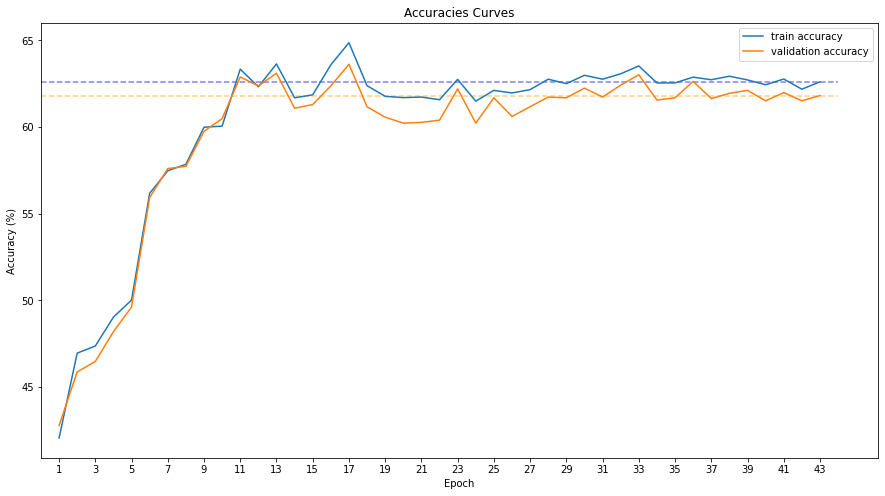

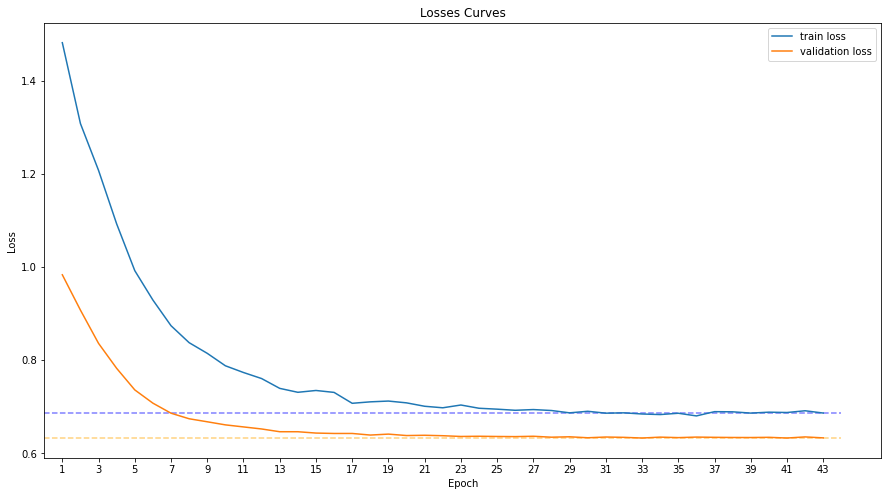

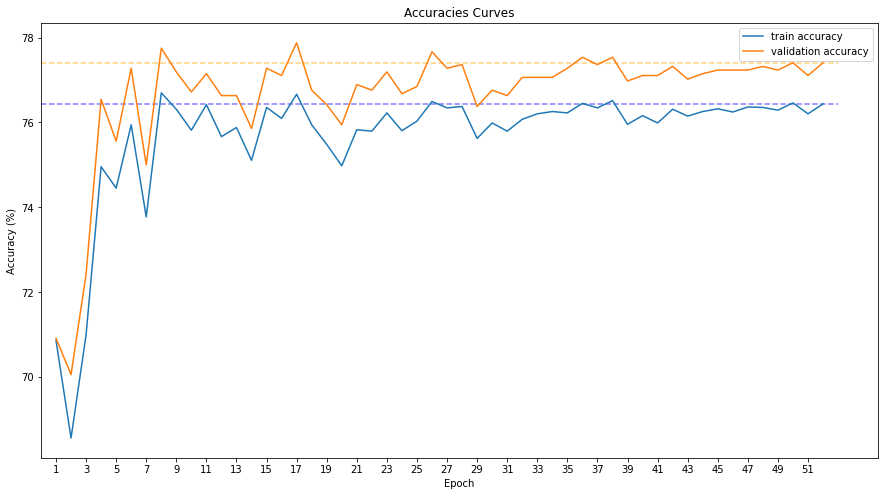

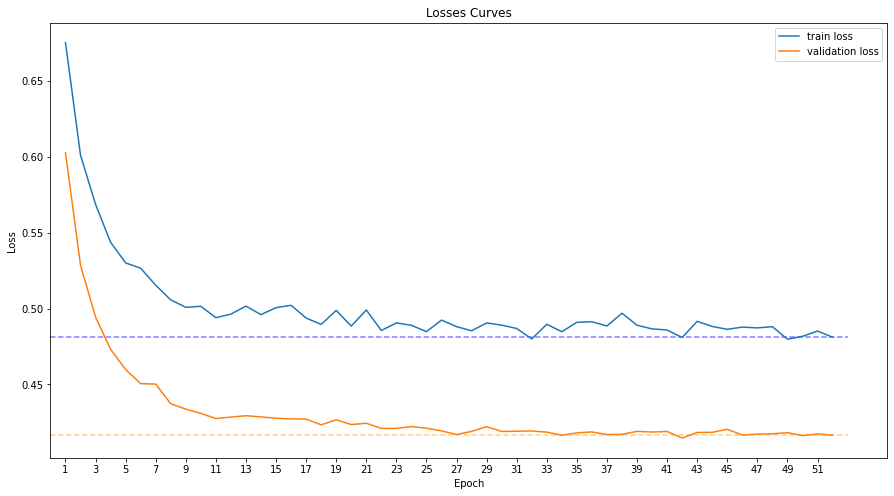

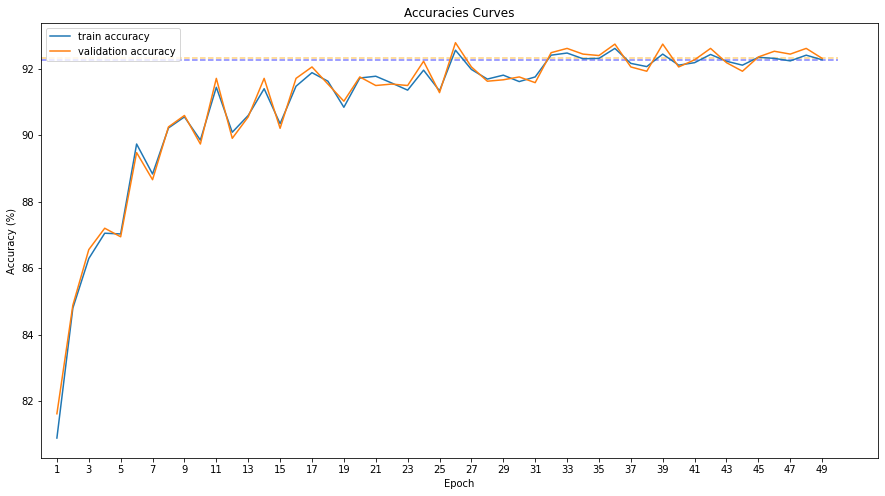

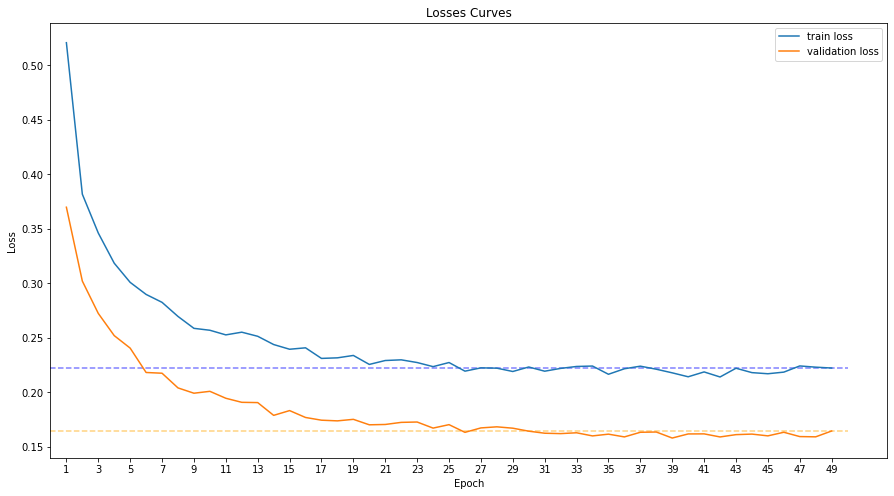

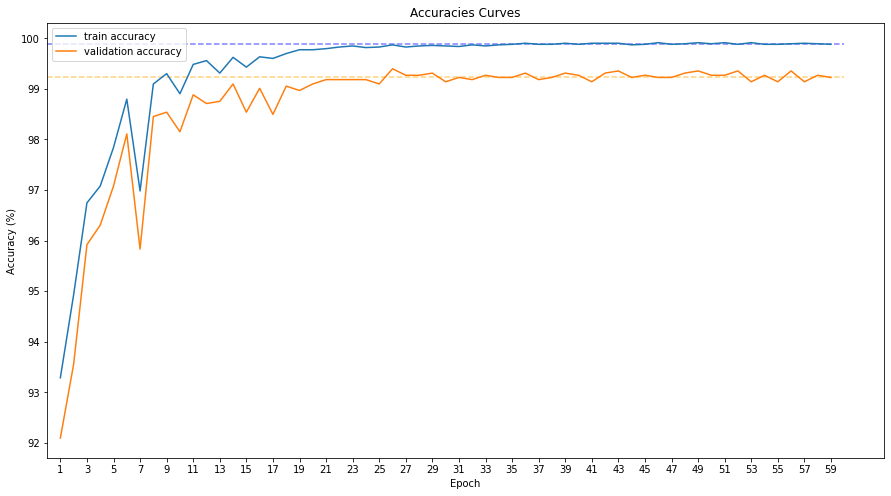

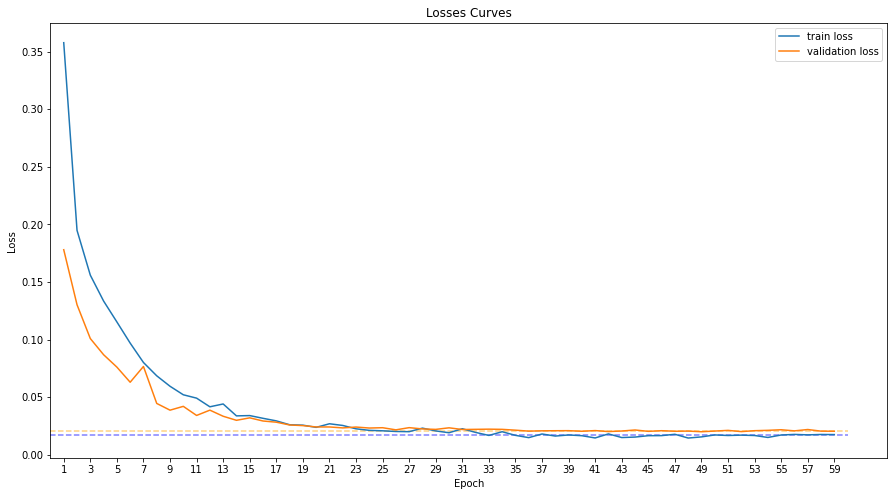

In [ ]:
accuracies = []
times = []
for layers in range(1,5):
    test_accuracy,time_elapsed = train_freezed(layers)
    accuracies.append(test_accuracy)
    times.append(time_elapsed)

accuracies.append(ptb_test_accuracy)
times.append(ptb_time_elapsed)

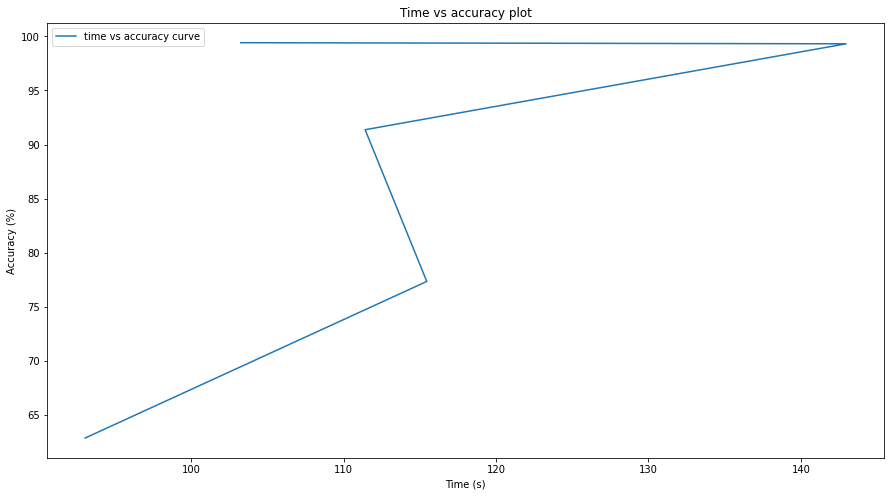

In [ ]:
# time vs accuracy plot
figure = plt.figure(figsize=(15,8))
ax = figure.add_subplot(1,1,1)
ax.plot(times,accuracies,label = "time vs accuracy curve")
ax.legend()
ax.set_title("Time vs accuracy plot")
ax.set_xlabel("Time (s)")
_=ax.set_ylabel("Accuracy (%)")

In [ ]:
accuracies

[62.88659793814433,
 77.35395189003437,
 91.37457044673539,
 99.3127147766323,
 99.41580756013747]

In [ ]:
times

[93.04860472679138,
 115.46150708198547,
 111.4171884059906,
 142.96538400650024,
 103.26004981994629]

##Analysis of steps of the cnn layers

In [ ]:
def layer_outputs(ecg, model):
    [conv_module,lin_module] = [module for module in mit_model.modules() if isinstance(module, nn.Sequential)]
    outputs = [ecg]
    names = ["normal ecg"]
    for layer in conv_module:
        ecg = layer(ecg)
        outputs.append(ecg)
        names.append(str(layer))

    ecg = ecg.view(ecg.size(0), -1)

    for layer in lin_module:
        ecg = layer(ecg)
        outputs.append(ecg)
        names.append(str(layer))

    outputs[0]=outputs[0].squeeze(0)
    output_ecg = []
    for out in outputs:
      out = out.squeeze(0).T.data.cpu().numpy()
      if len(out.shape)==2:
        output_ecg.append(out)
      else:
        output_ecg.append(out)


    fig, ax = plt.subplots(len(output_ecg), 1, figsize=(20, 100))
    for i,out in enumerate(output_ecg):
        ax[i].plot(out)
        ax[i].set_title(f'{names[i]}')
        ax[i].set_xlabel('Time (ms)')
        ax[i].set_ylabel('Amplitude (mV)')


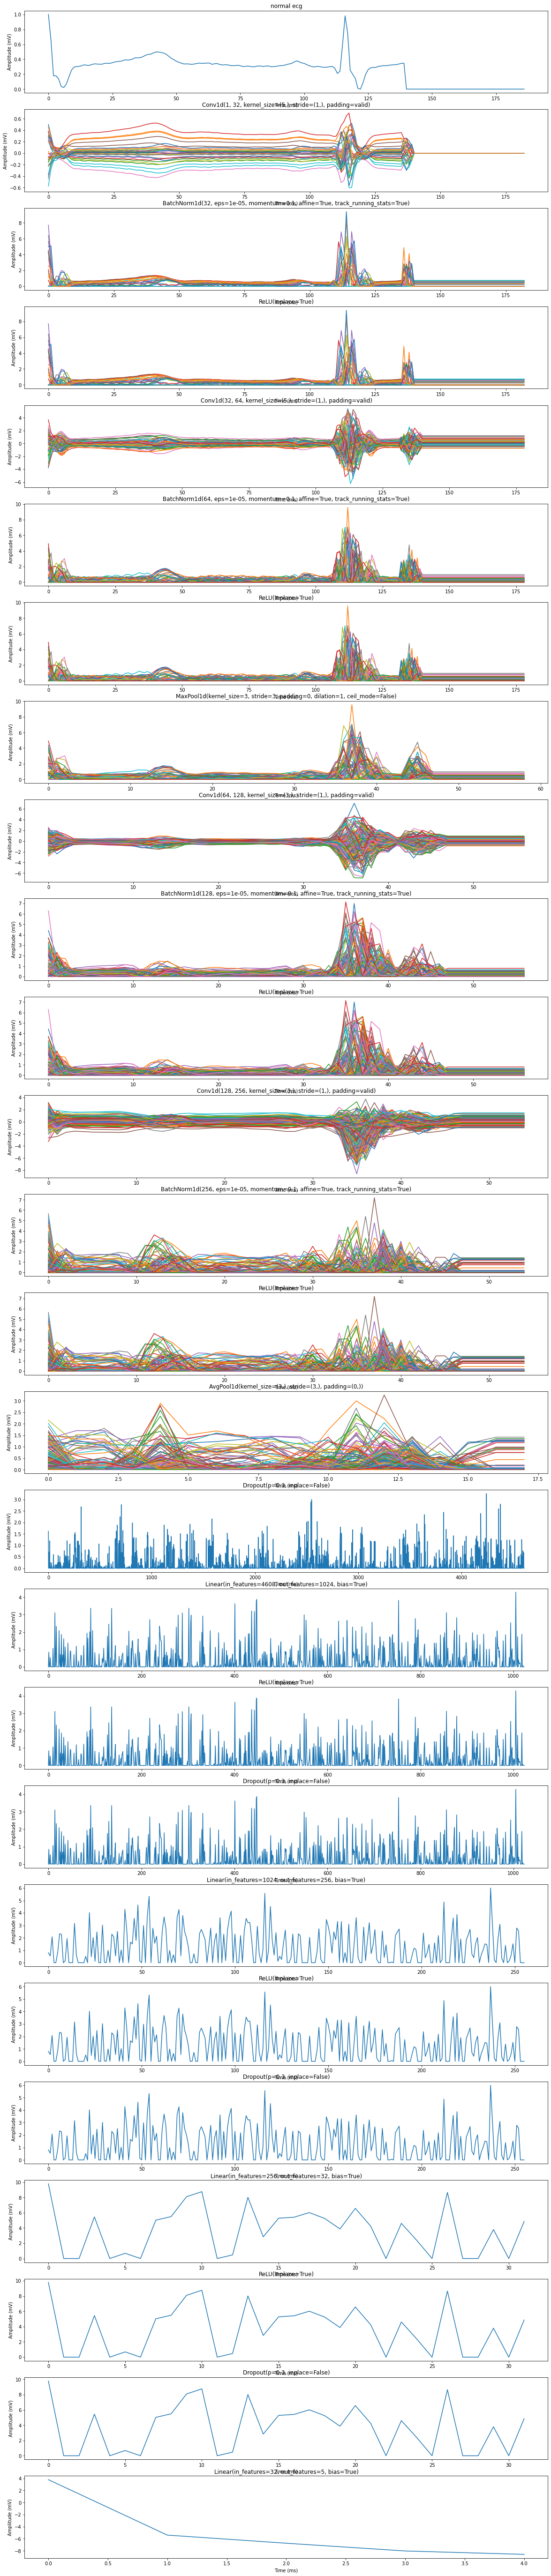

In [ ]:
layer_outputs(torch.tensor(mit_train.loc[10:10,:186].values,dtype = torch.float32).unsqueeze(1).to(device), mit_model)

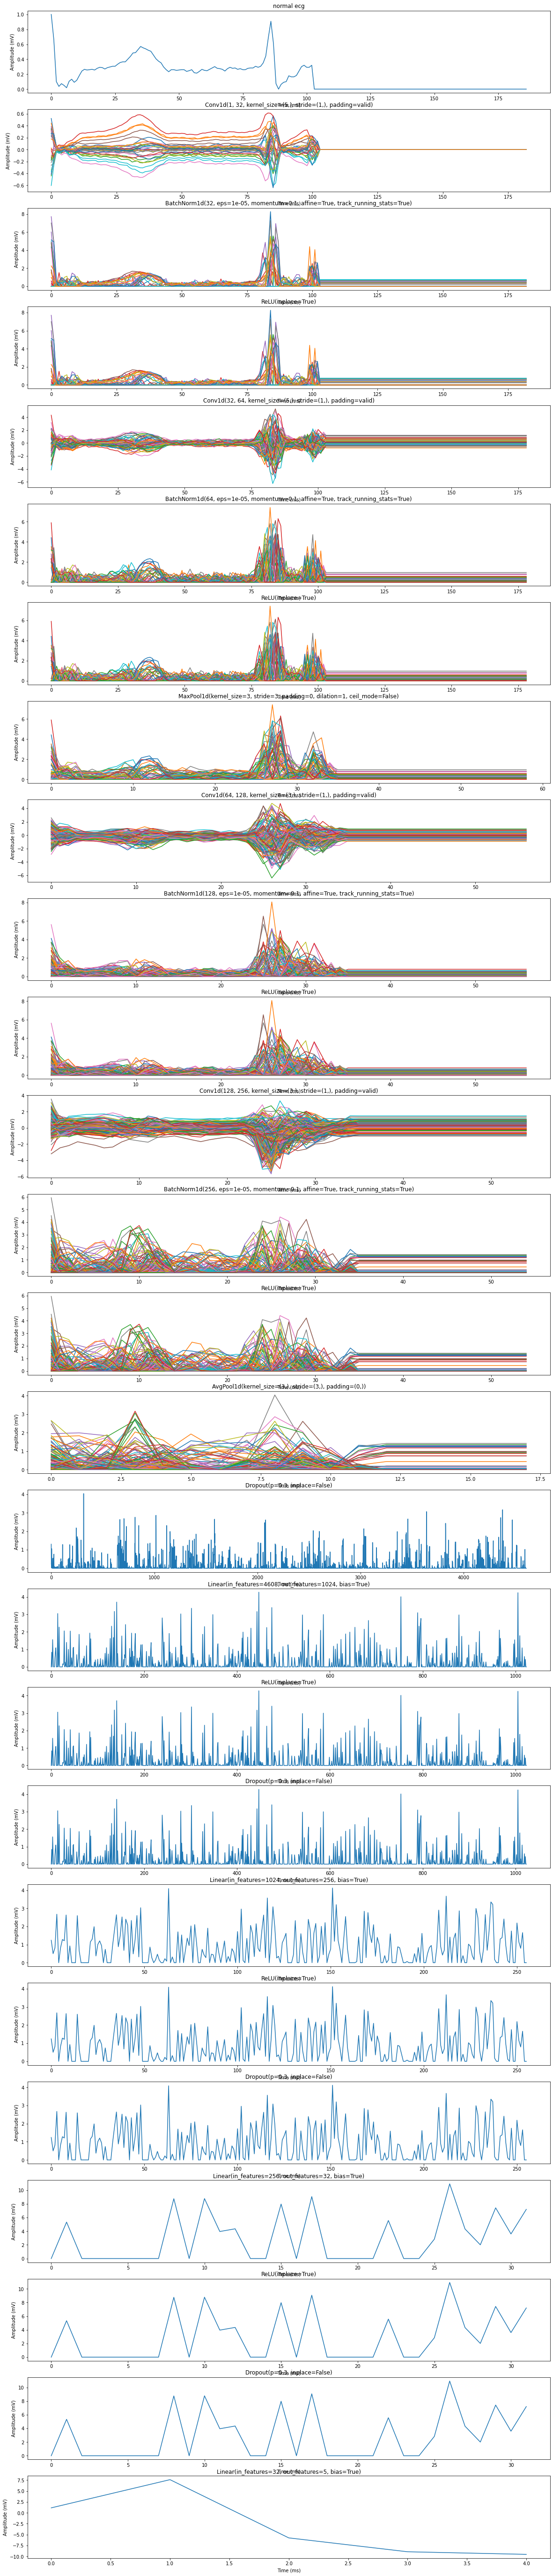

In [ ]:
layer_outputs(torch.tensor(mit_train.loc[72470:72470,:186].values,dtype = torch.float32).unsqueeze(1).to(device), mit_model)

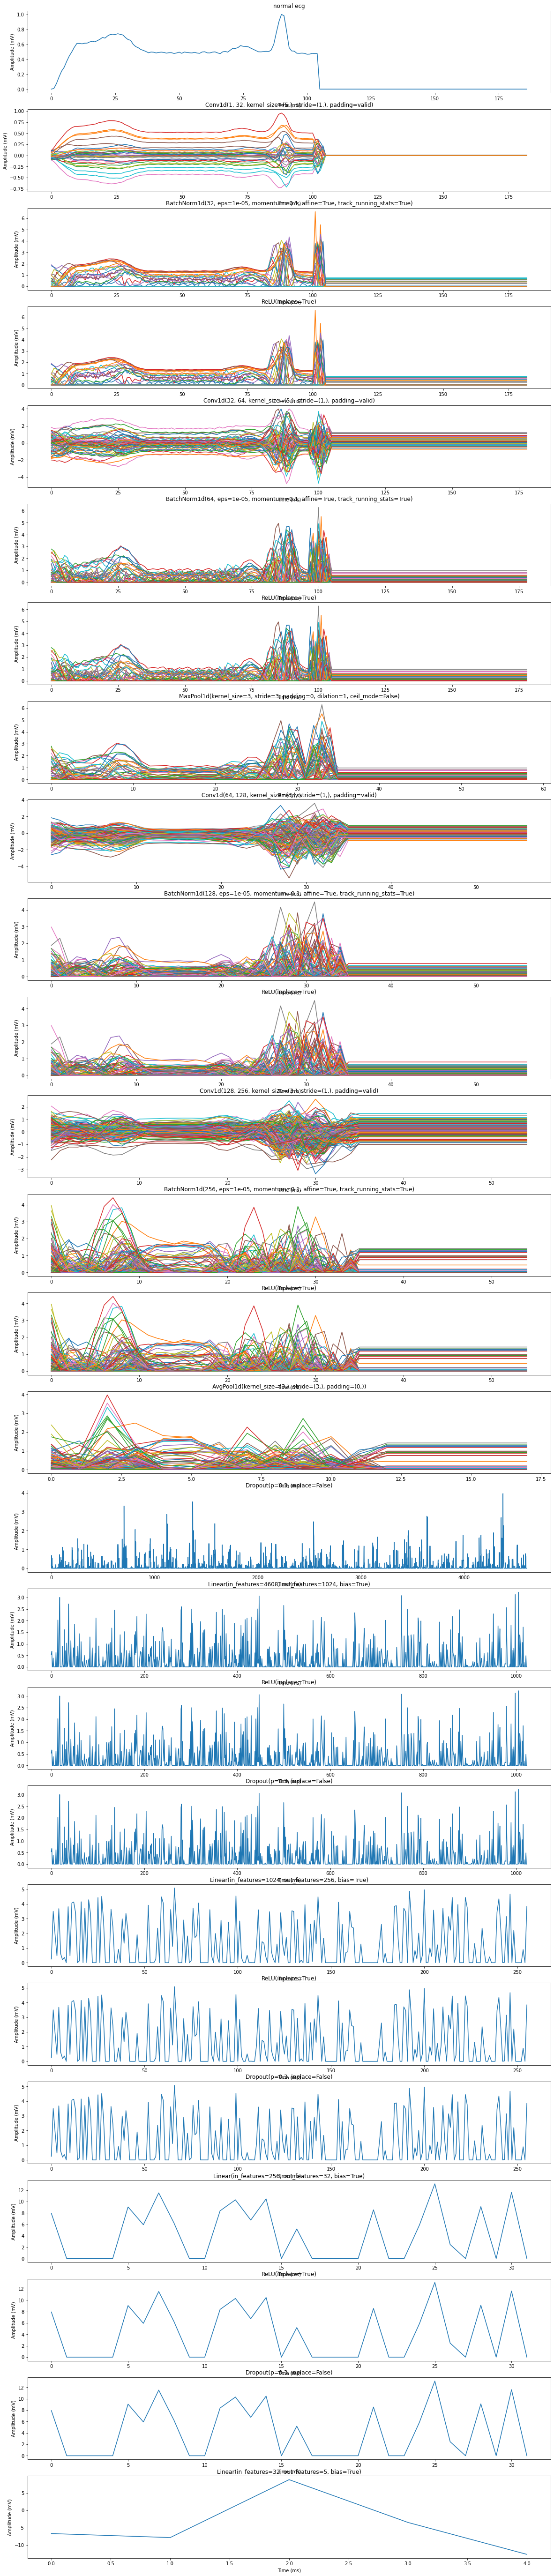

In [ ]:
layer_outputs(torch.tensor(mit_train.loc[74693:74693,:186].values,dtype = torch.float32).unsqueeze(1).to(device), mit_model)